## Como ganhar uma partida de League of Legends com estatística.

Neste notebook iremos fazer uma análise exploratória dos dados dos melhores jogadores de Lol de todo o mundo e entender quais são os fatores que levam uma partida à vitória ou derrota.

Nosso primeiro passo será coletar os dados das partidas na API da Riot Games, todos os dados são públicos e para fazer requisições é necessário um token de acesso à API. Há 16 servidores ativos de League of Legends em todo o mundo, sendo dividido em 4 regiões: Américas, Europa, Ásia e Oceania.

Estaremos analisando as últimas 100 partidas dos melhores jogadores de todos os servidores. Mas o que define quem são os melhores jogadores? Além do fato de alguns destes serem jogadores profissionais, os melhores jogadores estão no maior ranking do jogo: Challenger. Cada servidor possui entre 100 e 200 Challengers(cerca de 0.01% dos jogadores)

In [1]:
import requests
import pandas as pd
import time
import os
from dotenv import load_dotenv

Para fazer requisições para a  API da Riot Games, você precisa de um token de acesso. O token pode ser solicitado no link: https://developer.riotgames.com/

In [2]:
load_dotenv()
RGKEY = os.getenv("RGKEY")

Nosso primeiro passo é fazer a requisição dos ID's de todos os jogadores Challenger de todos os servidores do mundo. Para isso iremo definir um dicionário definindo a região de cada servidor, depois iremos iterar sobre esse dicionário e fazer os requests na rota **league-exp** usando o **servidor** como parâmetro.

In [11]:
regions = {
    'BR1': "AMERICAS",
    'EUN1': "EUROPE",
    'EUW1': "EUROPE",
    'JP1': "ASIA",
    'KR': "ASIA",
    'LA1': "AMERICAS",
    'LA2': "AMERICAS",
    'NA1': "AMERICAS",
    'OC1': "SEA",
    'PH2': "SEA",
    'RU': "EUROPE",
    'SG2': "SEA",
    'TH2': "SEA",
    'TR1': "EUROPE",
    'TW2': "SEA",
    'VN2': "SEA"
  }

In [12]:
summoners = []
for server, region in regions.items():
  URL = f"https://{server.lower()}.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/CHALLENGER/I?page=1&api_key={RGKEY}"
  response = requests.get(URL).json()
  for player in response:
    summoners.append({"summonerId": player["summonerId"], "region": region, "server": server})

In [15]:
summoners = pd.DataFrame(summoners).sample(1)

Para fazer a requisição das partidas de cada jogador, precisamos do **puuid**, que pode ser puxado através do **summoneId** que coletamos acima. Para isso iremos fazer requests na rota **summoner** e utilizar o **summonerId** e o **servidor** como parâmetros.

In [16]:
for i, row in summoners.iterrows():
  time.sleep(1)
  summoner_id = row['summonerId']
  server = row['server']

  URL = f"https://{server}.api.riotgames.com/lol/summoner/v4/summoners/{summoner_id}?api_key={RGKEY}"
  response = requests.get(URL).json()

  summoners.loc[i, 'puuid'] = response['puuid']

In [17]:
summoners

,summonerId,region,server,puuid
662,c9Nba54KkFQ6NI3qL9gY45xgMk7XSlg6AWWWcBaISzjPPq...,SEA,VN2,FYG7pdocudpaUZQMmAvavzbQXsIXGqPXBJsKlBsp6Ttgp7...


Agora nós temos o **puuid** de dos melhores jogadores do mundo. Nosso próximo passo será consultar as últimas 100 partidas de todos os jogadores. Cada partida tem um ID, vamos fazer a requisição dos **match_ids** utilizando a rota **match** utilizando o **puuid** e a **região** como parâmetros.

In [18]:
matchs = []
for i, row in summoners.iterrows():
  time.sleep(1)
  puuid = row['puuid']
  region = row['region']

  URL = f"https://{region}.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?type=ranked&start=0&count=100&api_key={RGKEY}"
  try:
    response = requests.get(URL).json()
    for id in response:
      matchs.append({'match_id': id, 'region': region})
  except:
    pass

In [19]:
matchs = pd.DataFrame(matchs)

In [20]:
matchs

,match_id,region
0,VN2_449182594,SEA
1,VN2_449156174,SEA
2,VN2_449118838,SEA
3,VN2_449096415,SEA
4,VN2_449047525,SEA
...,...,...
95,VN2_436545044,SEA
96,VN2_436498390,SEA
97,VN2_436457832,SEA
98,VN2_436436219,SEA


### Coletando os dados das partidas.

Agora chegamos no nosso último passo, que é coletar todos os dados de todas as partidas. Através da API da Riot, conseguimos informações como a rota em que o jogador jogou, quantidade de abates e mortes, quantidade de sentinelas e pings utilizados, quais itens foram comprados, com qual campeão ele estava jogando, etc...

Com todas essas informações, além de entender quais são os fatores que levam um jogador ao topo, poderemos analisar também quais são as melhores composições para times(não se esqueça que o lol é um jogo cooperativo), poderemos entender a melhor forma de construir uma composição que faça sentido para o time, combinações de campeões e itens, etc...

Para fazer a coleta dos dados, iremos utilizar a rota **match** novamente e passar o **match_id** como parâmetro. Também iremos criar um dataframe para cada rota, definidas na lista **positions**

In [21]:
tops, jgs, mids, adcs, sups = [], [], [], [], []
columns_to_remove = ['challenges', 'missions', 'perks']
setter = {'TOP': tops, 'JUNGLE': jgs, 'MIDDLE': mids, 'BOTTOM': adcs, 'UTILITY': sups}
positions = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']

In [22]:
for i, row in matchs.iterrows():
  time.sleep(1)
  match_id = row['match_id']
  region = row['region']

  URL = f"https://{region}.api.riotgames.com/lol/match/v5/matches/{match_id}?api_key={RGKEY}"
  try:
    response = requests.get(URL).json()
    participants = response['info']['participants']
    for participant in participants:
      for column in columns_to_remove:
        del participant[column]
      for position in positions:
        if participant['teamPosition'] == position:
          setter.get(position).append(participant)
  except:
    pass


In [ ]:
for key, value in setter.items():
  pd.DataFrame(value).to_excel(f'assets/{key}.xlsx')

## Entendendo quais são os fatores que fazem um jogador ganhar uma partida de League of Legends.

Finalmente temos todos os dados que precisamos para fazer nossa análise estatística. Foram coletados cerca de 35 mil dados para cada rota: top, jungle, mid, adc e suporte.
A estrutura de cada um dos DataFrame ficou um pouco complexa. Para diminuir a complexidade dos dados, iremos agrupar algumas colunas com significado parecido e remover colunas irrelevantes para nossa análise, também iremos unificar todos os dados. Depois iremos fazer uma análise descritiva com os dados.


In [35]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
tops = pd.read_excel("assets/TOP.xlsx")
jgs = pd.read_excel("assets/JUNGLE.xlsx")
mids = pd.read_excel("assets/MIDDLE.xlsx")
adcs = pd.read_excel("assets/BOTTOM.xlsx")
sups = pd.read_excel("assets/UTILITY.xlsx")

In [3]:
top_jgs = pd.concat([tops, jgs])
mids_adcs = pd.concat([mids, adcs])
matchs = pd.concat([top_jgs, mids_adcs])
matchs = pd.concat([matchs, sups])

# Diminuindo a complexidade dos dados

#### Unificando algumas colunas.

Como o Lol é um jogo cooperativo, a comunicação é um fator extremamente necessário. Para facilitar a comunicação entre os jogadores, o lol possui um sistema de Pings. Existem váios pings, cada um com um significado diferente, como recuar, atacar e por aí vai.
O tipo de ping não é um dado tão relevante assim, até porque o nível de agressividade ou passividade de um time ou jogador pode ser analisado através da quantidade de abates/ mortes e dano causado/sofrido.
Então iremos criar uma única coluna chamada **allPings** que será o agrupamento entre todas as colunas de Pings.

Iremos unificar as colunas **assists** e **kills** e chamá-la de **participations**. Uma assistência é quando um jogador ajuda à matar um jogador inimigo, kills é auto-explicativo. Ambos tem o mesmo efeito prático na partida.

Também iremos unificar as colunas **totalMinionsKilled, totalEnemyJungleMinionsKilled, totalAllyJungleMinionsKilled, neutralMinionsKilled** na coluna **totalFarm**

#### Removendo algumas colunas.

O DataFrame também possui uma coluna para ouro ganho e ouro gasto. Separar os dados dessa forma é irrelevante, iremos considerar apenas o ouro gasto na partida, pois o ouro ganho só tem efeito prático quando é gasto com itens. Iremos deletar a coluna **goldEarned**

Também iremos remover dados cujo partida tenha acabo com uma rendição logo no início da partida. A rendição no início da partida significa que algum dos jogadores não conseguiu se conectar no game. Esses dados são inúteis. A coluna que indica uma rendição rápida é **gameEndedInEarlySurrender**. Também iremos deletar **gameEndedInSurrender**.

Nós já temos o nome do campeão que o jogador pickou e o seu level total, então iremos desconsiderar as colunas **championId** e **champExperience**.

Também iremos deletar todas as colunas que indiquem abates múltiplos, como double-kills, triple-kills... Nós já teremos esses números na coluna **participations**. As colunas **doubleKills**, **tripleKills**, **quadraKills**, **pentaKills** **largestMultiKill**, **largestKillingSpree**, **killingSprees** serão deletadas.

Não precisamos de informações pessoais dos jogadores. Informações como nome de usuário, ícone, id, etc... As colunas **summonerName, summonerLevel, summonerId, riotIdTagline riotIdGameName, puuid, profileIcon, participantId, eligibleForProgression** serão todas removidas

O jogo também possui a mecânica de visão do mapa, todo o lado inimigo do mapa é invisível a não ser que haja visão em determinado local. A visão de mapa é um fator determinante para vencer uma partida. A visão é conquistada utilizando um item chamado **ward**, há alguns tipos de ward e toda ward que é colocada ou removida dá ao jogador um ponto de visão. Iremos considerar apenas o score de visão e remover as colunas **visionWardsBoughtInGame, wardsKilled, wardsPlaced, sightWardsBoughtInGame, detectorWardsPlaced**

Vamos remover a coluna **itemsPurchased** e utilizar apenas **consumablesPurchased** para ver se a compra excessiva de poções influencia no desempenho de um jogador(tenho a intuição de que sim), e também as colunas **damageDealtToBuildings** e **damageDealtToTurrets**, a coluna **damageDealtToObjectives** é a soma dessas outras duas, é o suficiente pra nossa análise.

As colunas **nexusKills**, **nexusLost** e **nexusTakedowns** tem uma correlação perfeita com a vitória(basicamente se você destrói o nexus você ganha a partida). Iremos deletá-las.

Iremos deletar a coluna **firstBloodKill** e considerar apenas **firstBloodAssist**, é o suficiente pra saber se um time começou com a primeira kill do jogo ou não.

Podemos deletar a coluna **deaths** e considerar apenas **totalTimeSpentDead**

Iremos remover colunas isoladas com significado irrelevante ou duplicado, como **championTransform, largestCriticalStrike, lane, role, inhibitorKills, physicalDamageDealt, physicalDamageTaken, firstTowerKill,
magicDamageDealt, magicDamageTaken, teamEarlySurrendered, totalDamageDealt, trueDamageDealt, 
trueDamageTaken, firstTowerKill, objectivesStolen, turretKills, teamPosition, totalDamageShieldedOnTeammates, totalTimeCCDealt, totalUnitsHealed**

Por último, iremos remover colunas que possuem sempre um valor único

In [4]:
ping_columns = []
for column in matchs.columns:
    if 'Pings' in str(column):
        ping_columns.append(column)

ping_columns

['allInPings',
 'assistMePings',
 'basicPings',
 'commandPings',
 'dangerPings',
 'enemyMissingPings',
 'enemyVisionPings',
 'getBackPings',
 'holdPings',
 'needVisionPings',
 'onMyWayPings',
 'pushPings',
 'visionClearedPings']

In [5]:
matchs['allPings'] = matchs[ping_columns].sum(axis=1)
matchs.drop(columns=ping_columns, inplace=True)

In [6]:
for colum in matchs.columns:
    if matchs[colum].nunique() == 1:
        print(colum) 
        matchs.drop(colum, axis=1, inplace=True)

placement
playerAugment1
playerAugment2
playerAugment3
playerAugment4
playerSubteamId
sightWardsBoughtInGame
subteamPlacement
unrealKills


In [7]:
matchs['participations'] = matchs['kills'] + matchs['assists']

In [8]:
matchs['totalFarm'] = matchs['totalMinionsKilled'] + matchs['totalEnemyJungleMinionsKilled'] + matchs['totalAllyJungleMinionsKilled'] + matchs['neutralMinionsKilled']

In [9]:
matchs = matchs[~matchs["gameEndedInEarlySurrender"]]

In [10]:
columns_to_delete = [
    "goldEarned",
    "championId",
    "champExperience",
    "doubleKills",
    "tripleKills",
    "quadraKills",
    "pentaKills",
    "largestMultiKill",
    "largestKillingSpree",
    "killingSprees",
    "summonerName", 
    "summonerLevel", 
    "summonerId", 
    "riotIdTagline", 
    "riotIdGameName", 
    "puuid", 
    "profileIcon", 
    "participantId", 
    "eligibleForProgression",
    "visionWardsBoughtInGame", 
    "wardsKilled", 
    "wardsPlaced", 
    "gameEndedInEarlySurrender",
    "assists",
    "kills",
    "gameEndedInSurrender",
    "totalMinionsKilled",
    "totalEnemyJungleMinionsKilled",
    "totalAllyJungleMinionsKilled",
    "neutralMinionsKilled",
    "detectorWardsPlaced",
    "championTransform",
    "itemsPurchased",
    "damageDealtToBuildings",
    "damageDealtToTurrets",
    "largestCriticalStrike", 
    "lane",
    "role",
    "nexusLost",
    "nexusKills",
    "nexusTakedowns",
    "firstBloodKill",
    "inhibitorKills",
    "physicalDamageDealt",
    "physicalDamageTaken",
    "firstTowerKill",
    "magicDamageDealt",
    "magicDamageTaken",
    "teamEarlySurrendered",
    "totalDamageDealt",
    "trueDamageDealt",
    "trueDamageTaken",
    "objectivesStolen",
    "deaths",
    "turretKills",
    "teamPosition",
    "totalDamageShieldedOnTeammates",
    "totalTimeCCDealt",
    "totalUnitsHealed"
]

In [11]:
matchs.drop(columns=columns_to_delete, inplace=True)

In [12]:
list(matchs.columns)

['baronKills',
 'bountyLevel',
 'champLevel',
 'championName',
 'consumablesPurchased',
 'damageDealtToObjectives',
 'damageSelfMitigated',
 'dragonKills',
 'firstBloodAssist',
 'firstTowerAssist',
 'goldSpent',
 'individualPosition',
 'inhibitorTakedowns',
 'inhibitorsLost',
 'item0',
 'item1',
 'item2',
 'item3',
 'item4',
 'item5',
 'item6',
 'longestTimeSpentLiving',
 'magicDamageDealtToChampions',
 'objectivesStolenAssists',
 'physicalDamageDealtToChampions',
 'spell1Casts',
 'spell2Casts',
 'spell3Casts',
 'spell4Casts',
 'summoner1Casts',
 'summoner1Id',
 'summoner2Casts',
 'summoner2Id',
 'teamId',
 'timeCCingOthers',
 'timePlayed',
 'totalDamageDealtToChampions',
 'totalDamageTaken',
 'totalHeal',
 'totalHealsOnTeammates',
 'totalTimeSpentDead',
 'trueDamageDealtToChampions',
 'turretTakedowns',
 'turretsLost',
 'visionScore',
 'win',
 'allPings',
 'participations',
 'totalFarm']

In [13]:
matchs.shape

(177968, 49)

In [14]:
matchs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177968 entries, 0 to 35872
Data columns (total 49 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   baronKills                      177968 non-null  int64 
 1   bountyLevel                     177968 non-null  int64 
 2   champLevel                      177968 non-null  int64 
 3   championName                    177968 non-null  object
 4   consumablesPurchased            177968 non-null  int64 
 5   damageDealtToObjectives         177968 non-null  int64 
 6   damageSelfMitigated             177968 non-null  int64 
 7   dragonKills                     177968 non-null  int64 
 8   firstBloodAssist                177968 non-null  bool  
 9   firstTowerAssist                177968 non-null  bool  
 10  goldSpent                       177968 non-null  int64 
 11  individualPosition              177968 non-null  object
 12  inhibitorTakedowns              1779

# Finalizando a limpeza de dados.

Com todas as limpezas que fizemos, conseguimos reduzir a quantidade de colunas do nosso DataFrame de 127 para 49... Agora nós temos uma base de dados com a seguinte estrutura:

| Nome da Variável | Tipo | Descrição
|------------------|------|----------| 
| baronKills       | int  | Quantidade de barões de nashor feitos |
| bountyLevel      | int  | O nível de recompensa do jogador(quantidade de ouro que ele está valendo) |
| champLevel       | int  | O nível do campeão |
| championName     | str  | O nome do campeão  |
| consumablesPurchased | int | A quantidade de itens consumíveis comprados |
| damageDealtToObjectives | int | O total de dano dado em objetivos |
| damageSelfMitigated | int | O total de dano auto-mitigado de inimigos |
| dragonKills | int | Quantidade de dragões feitos |
| firstBloodAssist | bool | Se o jogador teve participação na primeira kill do jogo |
| firstTowerAssist | bool | Se o jogador teve participação na primeira torre derrubada no jogo |
| goldSpent | int | Total de ouro gasto durante a partida
| individualPosition | str | A posição na qual o jogador jogou |
| inhibitorTakedowns | int | Quantidade de inibidores derrubados |
| inhibitorsLost | int | Quantidade de inibidores perdidos |
| item0 | int | ID do Item 0 |
| item1 | int | ID do Item 1 |
| item2 | int | ID do Item 2 |
| item3 | int | ID do Item 3 |
| item4 | int | ID do Item 4 |
| item5 | int | ID do Item 5 |
| item6 | int | ID do Item 6 |
| longestTimeSpentLiving | int | Maior quantidade de tempo sem morrer |
| magicDamageDealtToChampions | int | Total de dano mágico causado |
| objectivesStolenAssists | int | Quantidade de participações em objetivos roubados |
| physicalDamageDealtToChampions | int | Dano físico causado em outros jogadores |
| spell1Casts | int | Quantidade que a skill "Q" foi utilizada |
| spell2Casts | int | Quantidade que a skill "W" foi utilizada | 
| spell3Casts | int | Quantidade que a skill "E" foi utilizada |
| spell4Casts | int | Quantidade que a skill "R" foi utilizada |
| summoner1Casts | int | Quantidade que a skill "D" foi utilizada |
| summoner2Casts | int | Quantidade que a skill "F" foi utilizada |
| summoner1Id | int | ID do feitiço de invocador 1 |
| summoner2Id | int | ID do feitiço de invocador 2 |
| teamId | int | O lado do mapa que o jogador jogou |
| timeCCingOthers | int | Tempo de atordoamento causado à jogadores inimigos |
| timePlayed | int | Tempo de partida | 
| totalDamageDealtToChampions | int | Dano total causado |
| totalDamageTaken |int | Dano total sofrido |
| totalHeal | int | Cura total recebida |
| totalHealsOnTeammates | int | Cura total dada ao time aliado |
| totalTimeSpentDead | int | Tempo passado morto |
| trueDamageDealtToChampions | int | Total de dano verdadeiro causado |
| turretTakedowns | int | Quantidade de torres derrubadas |
| turretsLost | int | Quantidade de torres perdidas |
| visionScore | int | Score de visão |
| win | bool | Se a partida foi vencida ou não |
| allPings | int | Quantidade de pings feitos |
| participations | int | Quantidade de participações em abates | 
| totalFarm | int | Quantidade de farm |

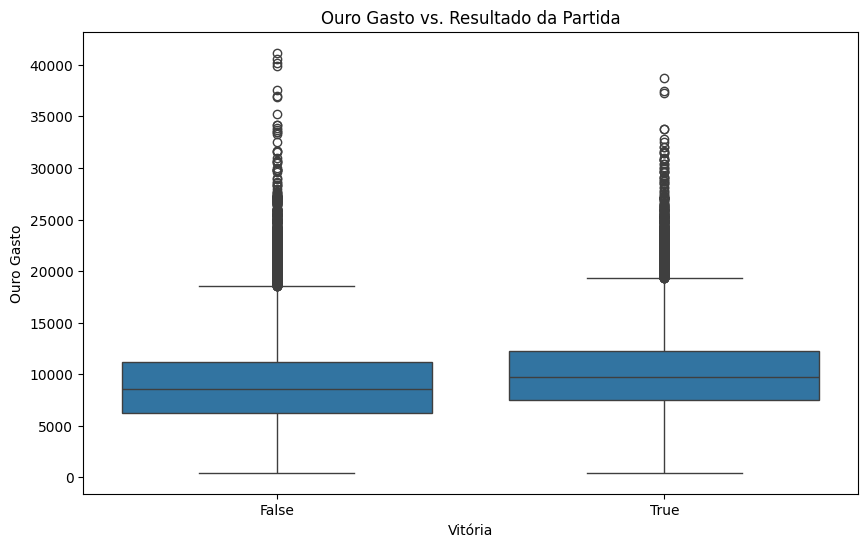

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=matchs, x='win', y='goldSpent')
plt.title('Ouro Gasto vs. Resultado da Partida')
plt.xlabel('Vitória')
plt.ylabel('Ouro Gasto')
plt.show()

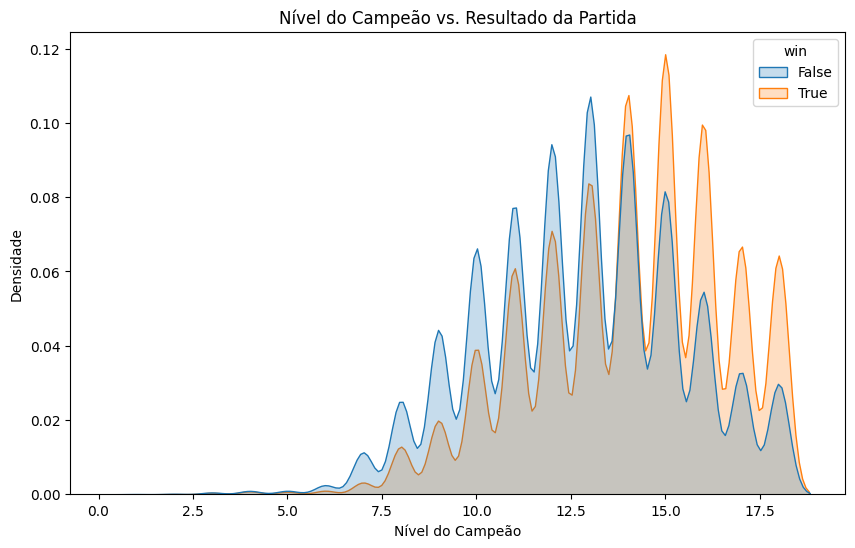

In [38]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=matchs, x='champLevel', hue='win', fill=True)
plt.title('Nível do Campeão vs. Resultado da Partida')
plt.xlabel('Nível do Campeão')
plt.ylabel('Densidade')
plt.show()

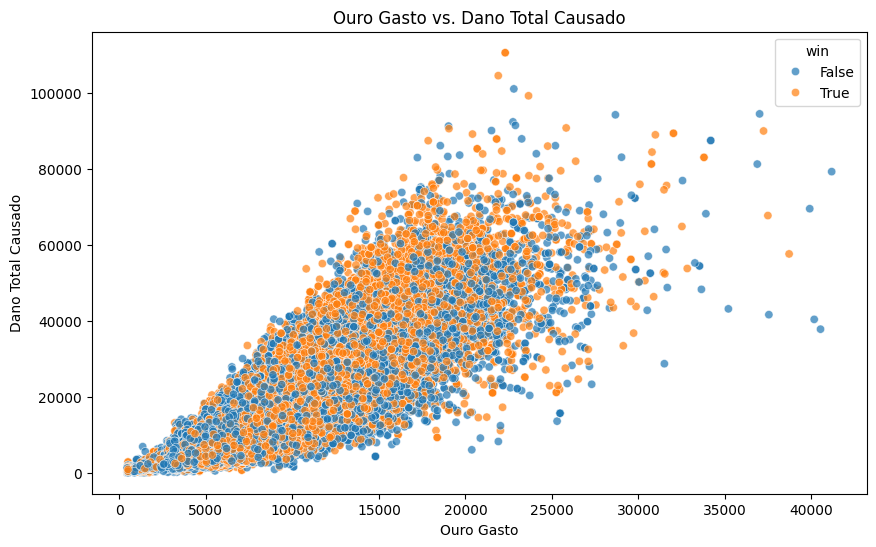

In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=matchs, x='goldSpent', y='totalDamageDealtToChampions', hue='win', alpha=0.7)
plt.title('Ouro Gasto vs. Dano Total Causado')
plt.xlabel('Ouro Gasto')
plt.ylabel('Dano Total Causado')
plt.show()

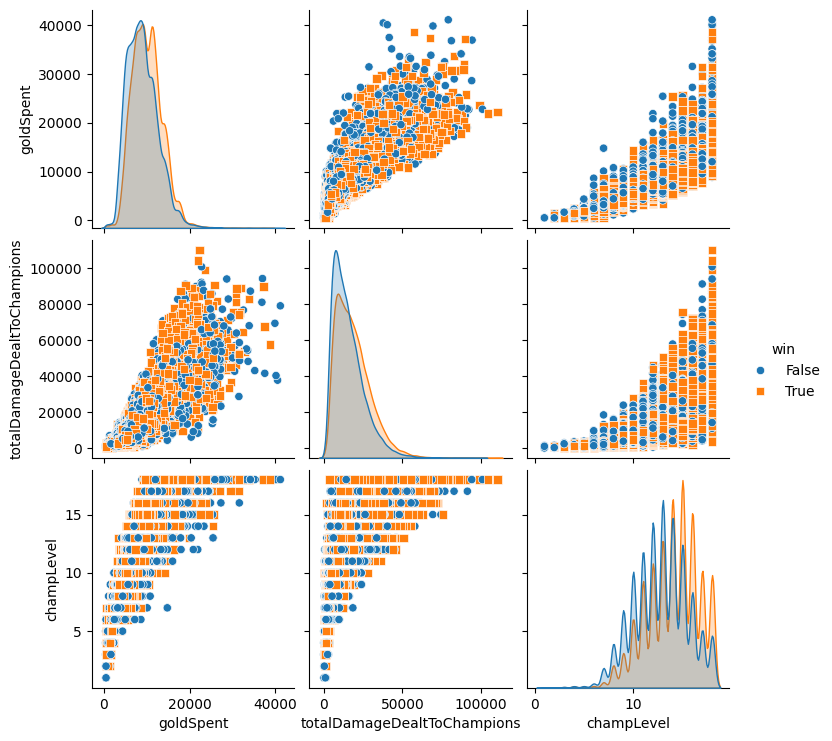

In [42]:
sns.pairplot(matchs[['goldSpent', 'totalDamageDealtToChampions', 'champLevel', 'win']], hue='win', markers=["o", "s"])
plt.show()